# Thyroid detection with the help of machine learning

In [93]:
import pandas as pd   # importing required Libraries
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  
from xgboost import XGBClassifier 
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

# Loading the dataset and adding the column names

In [94]:
df  = pd.read_csv("file:///C:/Users/rohan/Downloads/allhypo.data"  ,header= None)
df.head()
df.columns= ['age', 'sex','on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick',
       'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
       'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
       'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured',
       'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured',
       'TBG', 'referral source', 'target']

In [95]:
df.target.head()

0    negative.|3733
1    negative.|1442
2    negative.|2965
3     negative.|806
4    negative.|2807
Name: target, dtype: object

In [96]:
Target = df['target'].str.split('.', expand=True)  #removing useless values from the target 
df.drop(columns= 'target')
df['Target'] = Target[0] 

In [97]:
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,target,Target
0,41,F,f,f,f,f,f,f,f,f,...,125,t,1.14,t,109,f,?,SVHC,negative.|3733,negative
1,23,F,f,f,f,f,f,f,f,f,...,102,f,?,f,?,f,?,other,negative.|1442,negative
2,46,M,f,f,f,f,f,f,f,f,...,109,t,0.91,t,120,f,?,other,negative.|2965,negative
3,70,F,t,f,f,f,f,f,f,f,...,175,f,?,f,?,f,?,other,negative.|806,negative
4,70,F,f,f,f,f,f,f,f,f,...,61,t,0.87,t,70,f,?,SVI,negative.|2807,negative


# Removing unwanted columns

In [98]:
df = df.drop(columns= ["referral source" , "target" , "TBG" ])

In [99]:
df = df.replace(to_replace= '?' , value= np.nan) #The dataset have some nan values but they are assigned as ? so making it nan

# Most of the columns in the dataset have values like True and false ,so encoding the string value to int True = 1 , False = 0

In [100]:
df = df.replace(to_replace= ['t','f'] , value= [1,0]) 

In [102]:
df.Target.unique()

array(['negative', 'compensated hypothyroid', 'primary hypothyroid',
       'secondary hypothyroid'], dtype=object)

# changing the dtype of columns from object to int

In [59]:
df.age = pd.to_numeric(df.age)
df.TSH = pd.to_numeric(df.TSH)
df.T3 = pd.to_numeric(df.T3)
df.TT4 = pd.to_numeric(df.TT4)
df.T4U=pd.to_numeric(df.T4U)
df.FTI=pd.to_numeric(df.FTI)

# Now we need to encode the target class :starting from  Negative = 1 Till secondary Hypothyroid =3 

In [60]:
df.Target.unique()
df.Target = df.Target.replace(to_replace=['negative', 'compensated hypothyroid', 'primary hypothyroid',
       'secondary hypothyroid'] , value = [0,1,2,3] )

# One hot encoding for Sex column

In [61]:
Male = pd.get_dummies(df.sex ).M
Female = pd.get_dummies(df.sex).F
df["Male"] = Male
df["Female"] = Female
df=df.drop(columns="sex")

# summarizing the data report

In [62]:
PR = ProfileReport(df)
PR.to_widgets()

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Removing unwanted columns

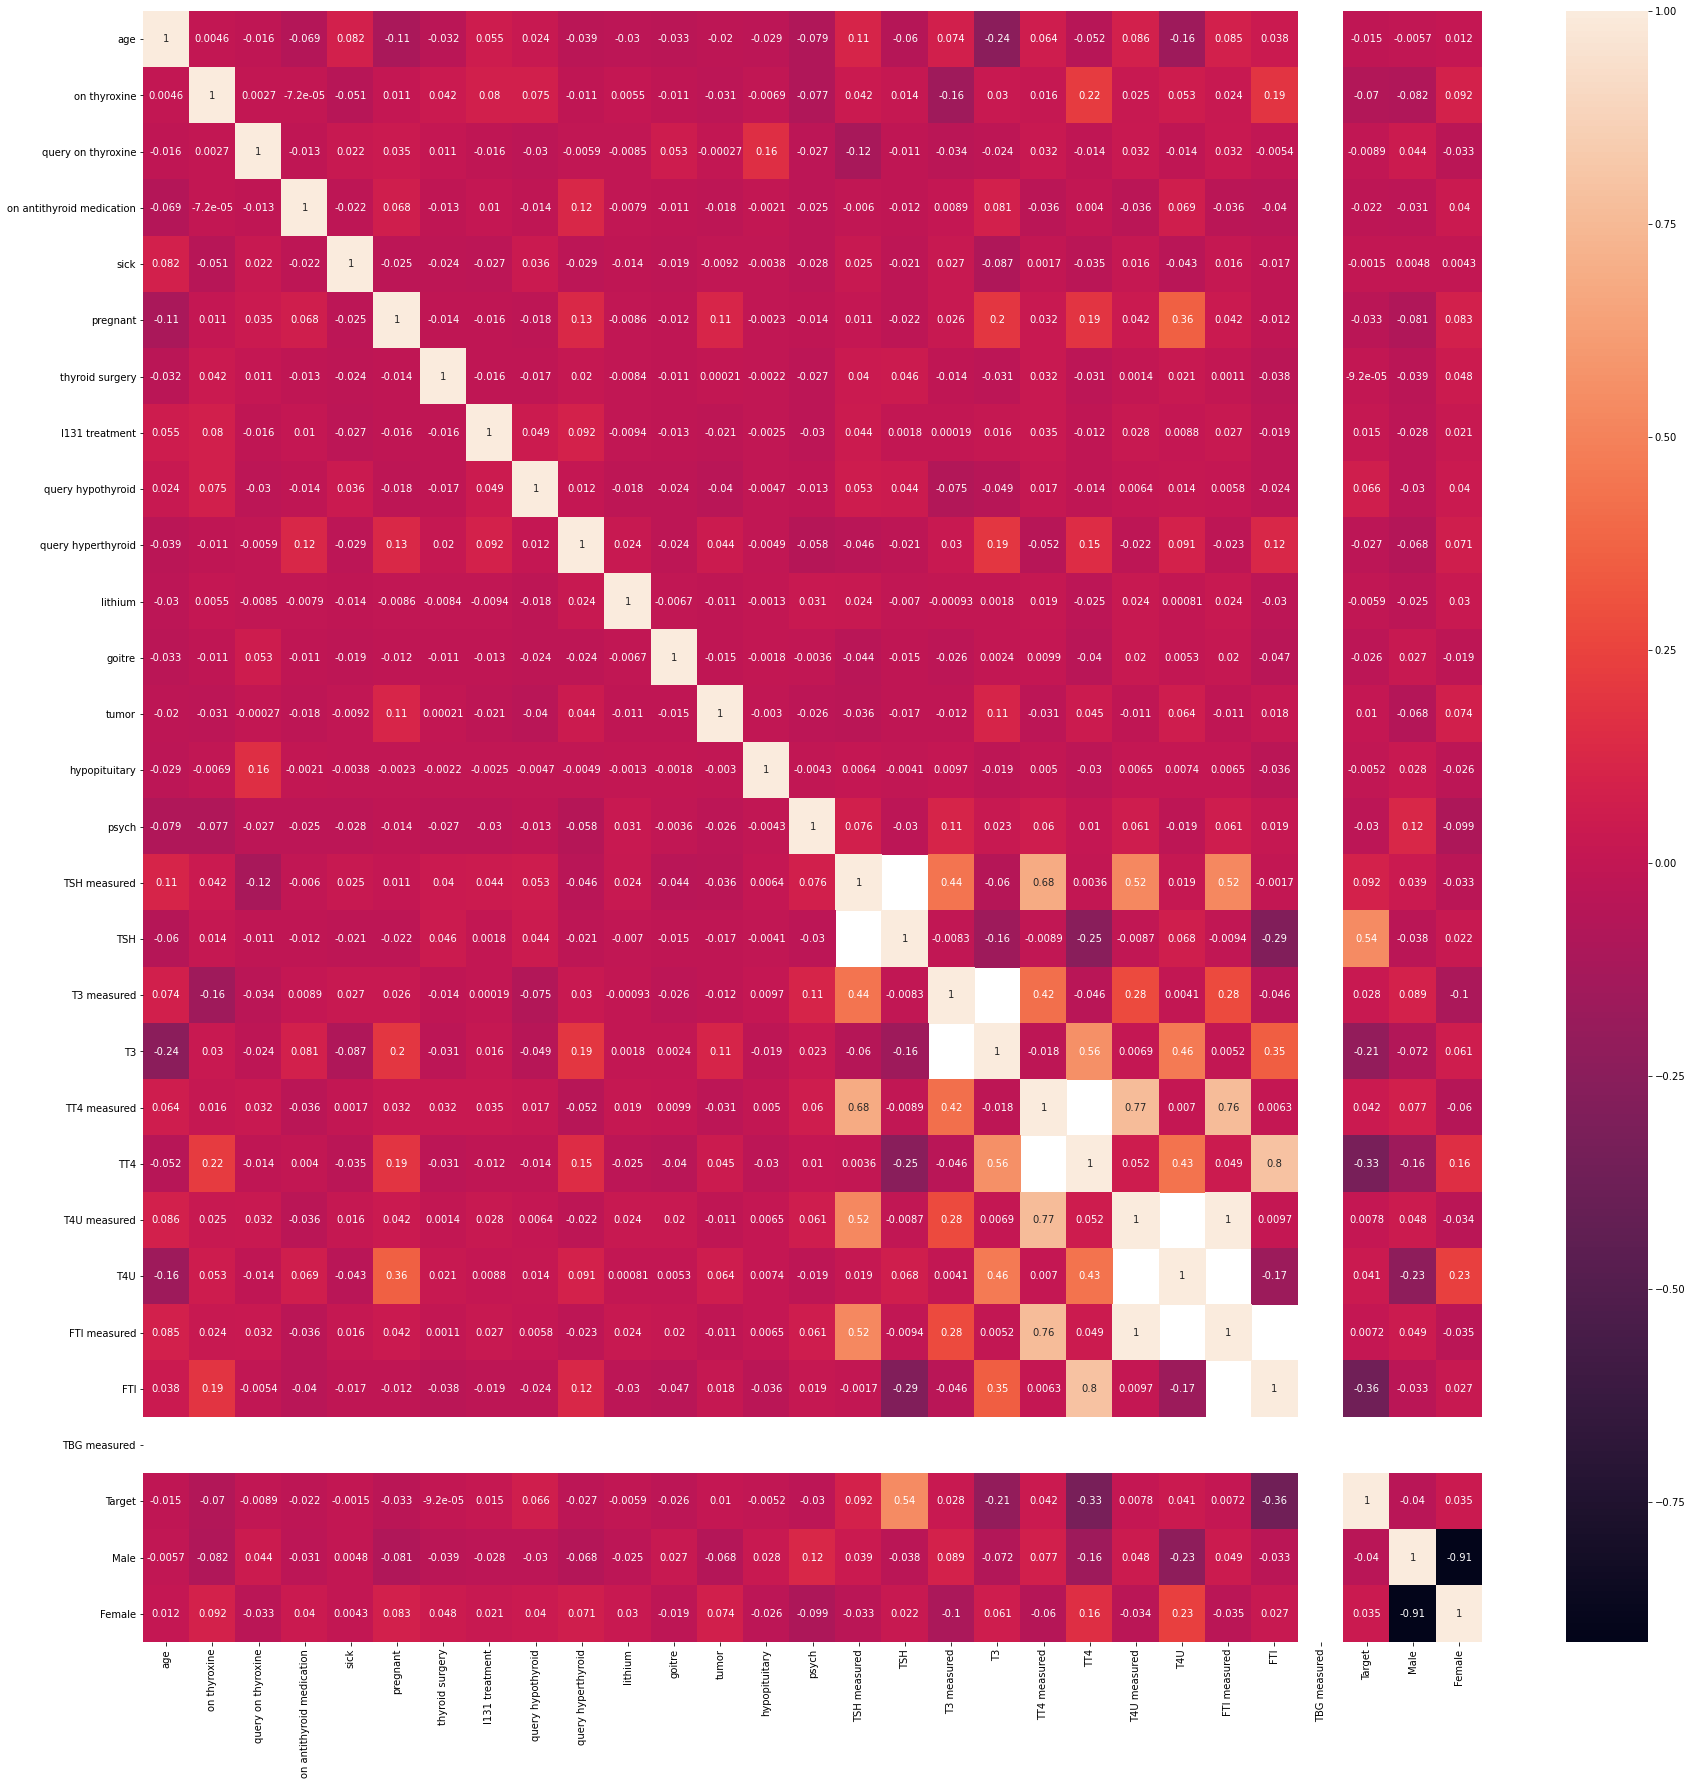

In [63]:
plt.figure(figsize= (30,30))
sns.heatmap(df.corr() , annot = True)
plt.show()

In [64]:
df =df.drop(columns=['TBG measured','FTI measured','T4U measured','TT4'
                    ,'hypopituitary','lithium','query on thyroxine','sick'])

#dropping the columns which have too less correlation with the target variable

# Handling the null values

In [65]:
imputer = KNNImputer(n_neighbors=2)
df = imputer.fit_transform(df)
df = pd.DataFrame(df,columns=['age', 'on thyroxine', 'on antithyroid medication', 'pregnant',
       'thyroid surgery', 'I131 treatment', 'query hypothyroid',
       'query hyperthyroid', 'goitre', 'tumor', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'T4U', 'FTI', 'Target', 'Male',
       'Female'])
df.head()

#imputing the null values with the knn imputer

,age,on thyroxine,on antithyroid medication,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,goitre,tumor,...,TSH measured,TSH,T3 measured,T3,TT4 measured,T4U,FTI,Target,Male,Female
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.30,1.0,2.5,1.0,1.140,109.0,0.0,0.0,1.0
1,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.10,1.0,2.0,1.0,1.225,109.0,0.0,0.0,1.0
2,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.98,0.0,1.4,1.0,0.910,120.0,0.0,1.0,0.0
3,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.16,1.0,1.9,1.0,0.910,147.5,0.0,0.0,1.0
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.72,1.0,1.2,1.0,0.870,70.0,0.0,0.0,1.0


# Fetaure selection with the help of mutual information gain

In [66]:
mutual_info=mutual_info_classif(df.drop(columns='Target'),df.Target)

In [67]:
mutual_data=pd.Series(mutual_info,index=df.drop(columns=
           'Target').columns)
mutual_data.sort_values(ascending=False)

TSH                          0.243875
FTI                          0.090801
T3                           0.026632
on thyroxine                 0.012997
on antithyroid medication    0.012918
T3 measured                  0.010153
query hypothyroid            0.008951
pregnant                     0.008658
age                          0.007014
T4U                          0.006871
TT4 measured                 0.006293
tumor                        0.004610
goitre                       0.002683
TSH measured                 0.002670
Male                         0.000000
psych                        0.000000
query hyperthyroid           0.000000
I131 treatment               0.000000
thyroid surgery              0.000000
Female                       0.000000
dtype: float64

In [68]:
df = df.drop(columns=['TT4 measured','T4U','tumor','query hyperthyroid','thyroid surgery','pregnant'])

# Checking outliers

<AxesSubplot:>

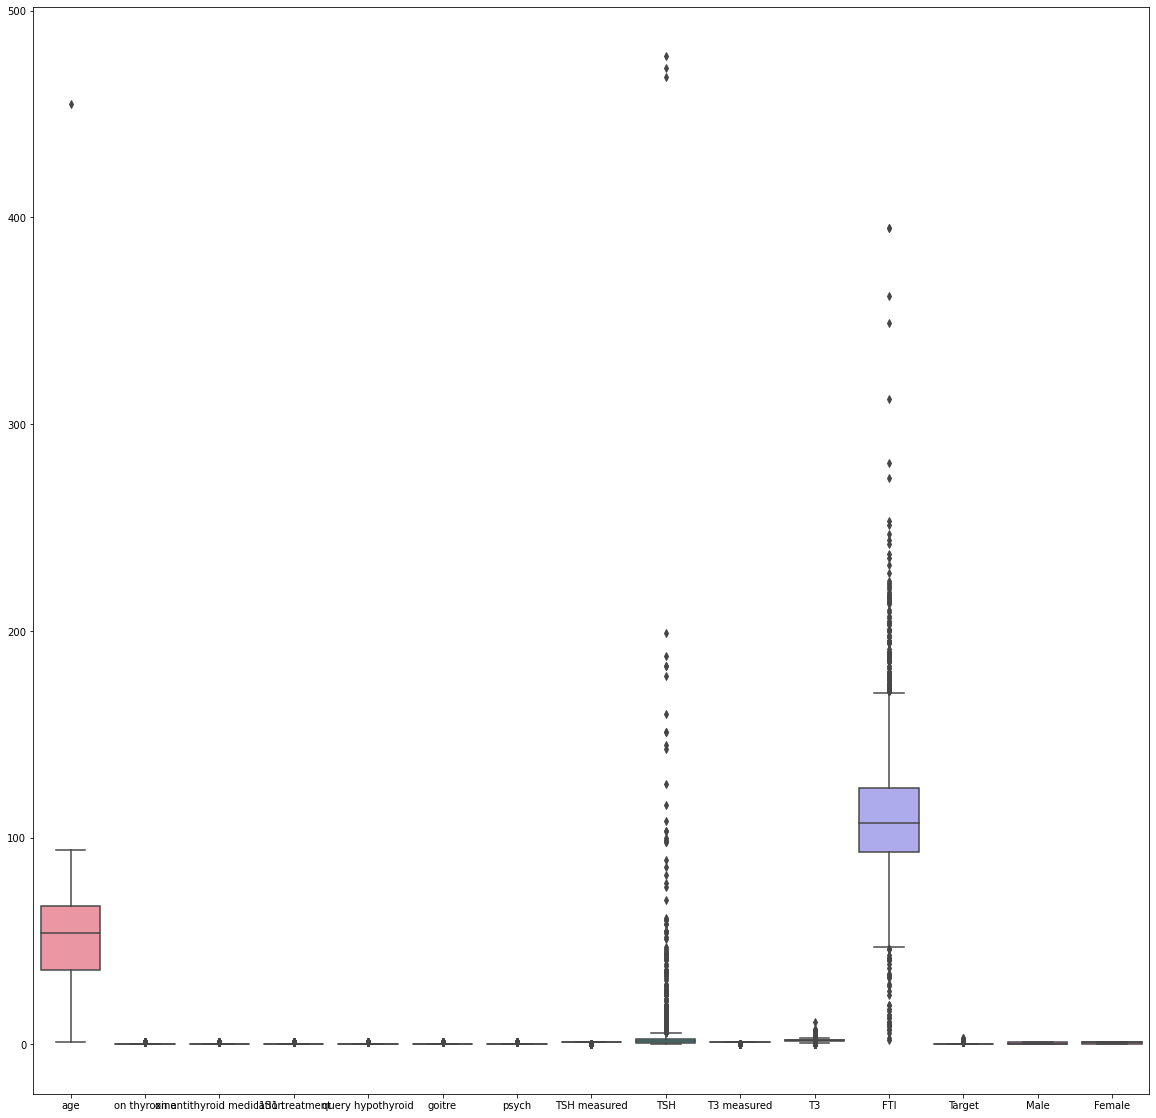

In [70]:
 plt.subplots(figsize = (20,20))
sns.boxplot(data=df)

# Removing outliers from the tsh column

In [71]:
q = df['TSH'].quantile(.99)
df = df[df['TSH']<q]

<AxesSubplot:>

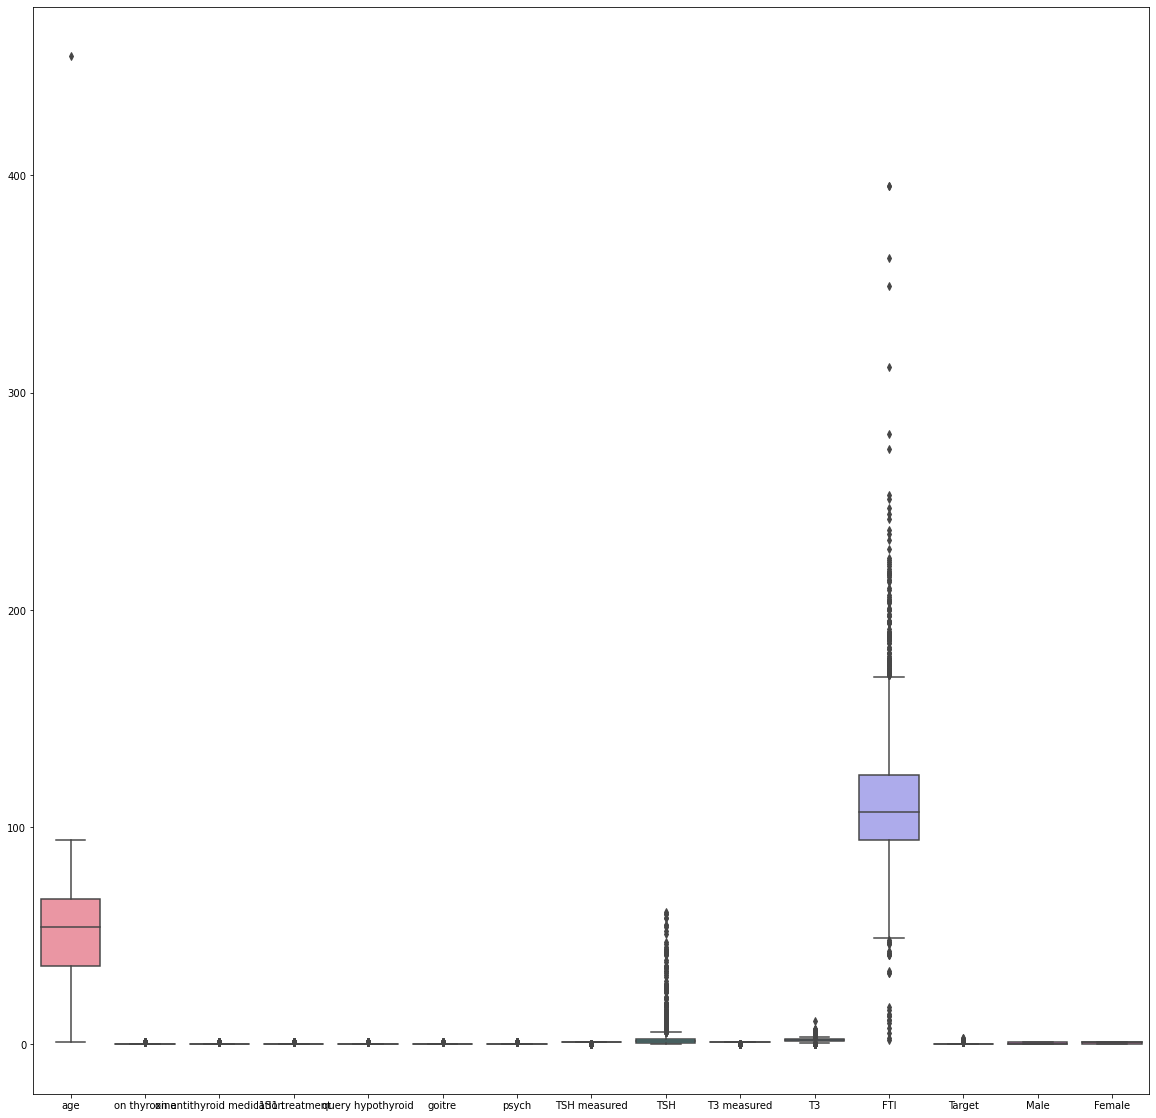

In [72]:
plt.subplots(figsize = (20,20))
sns.boxplot(data=df)

# It looks good now

In [74]:
X = df.drop(columns=
           'Target')  #features
y = df.Target   #target

# Standarzing the features dataframe 

In [75]:
sd_sc=StandardScaler()
x = sd_sc.fit_transform(X)

In [76]:
x

array([[-0.53162018, -0.36507372, -0.11143529, ..., -0.07748697,
        -0.66671009,  0.72903478],
       [-1.41065387, -0.36507372, -0.11143529, ..., -0.07748697,
        -0.66671009,  0.72903478],
       [-0.28744416, -0.36507372, -0.11143529, ...,  0.28006945,
         1.4999023 , -1.37167667],
       ...,
       [ 1.12877679, -0.36507372, -0.11143529, ...,  2.32789259,
         1.4999023 , -1.37167667],
       [ 0.39624871, -0.36507372, -0.11143529, ...,  0.31257458,
        -0.66671009,  0.72903478],
       [ 1.42178802, -0.36507372, -0.11143529, ...,  0.1175438 ,
        -0.66671009,  0.72903478]])

# Splitting into train test , so that we can have some data for testing also

In [77]:
x_train, x_test , y_train , y_test =train_test_split(x,y,test_size=.20 , random_state=30)

In [78]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((2217, 14), (555, 14), (2217,), (555,))

# Making models

In [79]:
LR = LogisticRegression() #Linear Regression model
LR.fit(x_train,y_train)

LogisticRegression()

In [80]:
RD_C = RandomForestClassifier() #Random forest model
RD_C.fit(x_train , y_train)

RandomForestClassifier()

In [81]:
xgb =XGBClassifier()   #XGboost model
xgb.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
#making a fucntion for getting report of all the models in one short
def modelsscores(clf,x_train , y_train , x_test,y_test):
    for i in clf:
        a = str(i)
        y_pred=i.predict(x_test)
        print(f'Train score for {a[:12]} is {i.score(x_train,y_train)}')
        print("---------------------------------")
        print(f'Test score for {a[:12]} is {i.score(x_test,y_test)}')
        print("---------------------------------")
        print(classification_report(y_pred,y_test))
        print("=============================================")


In [83]:
modelsscores([LR , RD_C , xgb] , x_train,y_train,x_test,y_test)

Train score for LogisticRegr is 0.9733874605322508
---------------------------------
Test score for LogisticRegr is 0.972972972972973
---------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       533
         1.0       0.63      0.85      0.72        20
         2.0       0.33      0.50      0.40         2
         3.0       0.00      0.00      0.00         0

    accuracy                           0.97       555
   macro avg       0.49      0.58      0.53       555
weighted avg       0.98      0.97      0.98       555

Train score for RandomForest is 1.0
---------------------------------
Test score for RandomForest is 0.9927927927927928
---------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       522
         1.0       1.00      0.90      0.95        30
         2.0       1.00      1.00      1.00         3
         3.0       0.00   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

# As we can see the XGboost model gave us the best accuracy and less overfit so we choose xgboost model

==============================================================================

# Lets do some hyperparameter tuning and check wether we can get more good fit

In [84]:
Params = {    'n_estimators' : [10,20,30,40,50],
          'learning_rate' : [0.005,0.3,0.04 , 0.10 , 0.5,0.6 , 0.10],
          'max_depth' : range(10,20),
          'random_state' : [30,90,100]

    
    
}

XGB = XGBClassifier()

In [85]:
Gr = GridSearchCV(estimator=XGB , param_grid= Params ,n_jobs=3 ) #Creating the Gridcv model
Gr.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[16:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [86]:
Gr.best_estimator_  #checking the best estimator

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
#Creating the model with best estimator
XGB_GR = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
XGB_GR.fit(x_train,y_train)

[16:20:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
y_pred = XGB_GR.predict(x_test)
print(f'Train score is {XGB_GR.score(x_train,y_train)} ')
print('-------------------------------')
print(f'Test score is {XGB_GR.score(x_test,y_test)}')
print('-------------------------------')
print(classification_report(y_pred,y_test))


Train score is 1.0 
-------------------------------
Test score is 0.9927927927927928
-------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       522
         1.0       1.00      0.90      0.95        30
         2.0       1.00      1.00      1.00         3
         3.0       0.00      0.00      0.00         0

    accuracy                           0.99       555
   macro avg       0.75      0.72      0.74       555
weighted avg       0.99      0.99      0.99       555



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Getting the same accuracy

======================================================================

# Lets check if the model is predicting well or not , Lets take a input from the data frame with 1 target

In [90]:
df[df.Target==1].tail(1)

,age,on thyroxine,on antithyroid medication,I131 treatment,query hypothyroid,goitre,psych,TSH measured,TSH,T3 measured,T3,FTI,Target,Male,Female
2767,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,2.5,94.0,1.0,0.0,1.0


In [91]:
XGB_GR.predict(sd_sc.transform(np.array([[24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,2.5,94.0,0.0,1.0]])))

array([1.])

# Our model is predicting well

# Saving model with pickle

In [92]:
import pickle
pickle.dump(XGB_GR,open('Internshipmodel.pickle', 'wb'))
pickle.dump(sd_sc,open('sd_sc_Intern', 'wb'))